In [1]:
!nvidia-smi

Wed Feb 14 21:59:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P8              19W / 215W |    368MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


40669.275077760496

In [10]:
l = [len(i) for i in x_test]
print(min(l))
print(max(l))
sum(l) / len(l)

20287
70470


40081.71915167095

In [11]:
def process(x, max_len=20000):
    y = []
    for i in x:
        i = i.squeeze()
        if len(i) > max_len:
            offset = max(0, (len(i) - max_len) // 2)
            yy = i[offset:offset+max_len]
        else:
            yy = i
        y.append(yy)
    return np.stack(y, axis=-1).T

In [12]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(process(x_train))[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = torch.tensor(process(x_test))[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [13]:
batch_size = 8
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [14]:
from IConNet.nn.model import M12

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
model_config_path = 'config/model/m15.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M15', 'description': 'FirConv sequential', 'fe': {'n_block': 2, 'n_channel': [64, 48], 'kernel_size': [511, 127], 'stride': [4, 4], 'groups': [1, 1], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'conv_type': 'firwin', 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm', 'pooling': False, 'n_fft': False}, 'seq': {'n_block': 1, 'n_channel': 48, 'pooling': 'mean', 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [128, 128], 'norm_type': 'LayerNorm'}}

In [17]:
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (pad): PadRight()
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(113, 48, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=144, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [18]:
from IConNet.visualizer import visualize_model

In [19]:
visualize_model.count_parameters(model)

102262

In [20]:
visualize_model.count_parameters(model.fe_blocks)

34576

In [21]:
import traceback

In [22]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [23]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [24]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                         | 0.0023894862604540022/10 [00:00<41:37, 249.82s/it]

Train Epoch: 1 [0/5144 (0%)]	Loss: 1.820617


  1%|▎                                                                         | 0.050179211469534045/10 [00:07<23:37, 142.43s/it]

Train Epoch: 1 [320/5144 (1%)]	Loss: 1.758580


  1%|▋                                                                          | 0.09796893667861428/10 [00:14<23:23, 141.73s/it]

Train Epoch: 1 [640/5144 (2%)]	Loss: 1.732737


  1%|█                                                                          | 0.14575866188769435/10 [00:21<23:21, 142.19s/it]

Train Epoch: 1 [960/5144 (2%)]	Loss: 1.326726


  2%|█▍                                                                          | 0.1935483870967741/10 [00:28<23:17, 142.48s/it]

Train Epoch: 1 [1280/5144 (3%)]	Loss: 1.771196


  2%|█▊                                                                         | 0.24133811230585386/10 [00:35<23:00, 141.47s/it]

Train Epoch: 1 [1600/5144 (4%)]	Loss: 1.446909


  3%|██▏                                                                        | 0.28912783751493365/10 [00:41<22:57, 141.87s/it]

Train Epoch: 1 [1920/5144 (5%)]	Loss: 1.491799


  3%|██▌                                                                         | 0.3369175627240134/10 [00:48<22:51, 141.97s/it]

Train Epoch: 1 [2240/5144 (5%)]	Loss: 1.403386


  4%|██▉                                                                        | 0.38470728793309317/10 [00:55<23:28, 146.46s/it]

Train Epoch: 1 [2560/5144 (6%)]	Loss: 1.380007


  4%|███▎                                                                        | 0.4324970131421729/10 [01:02<22:52, 143.47s/it]

Train Epoch: 1 [2880/5144 (7%)]	Loss: 1.722556


  5%|███▋                                                                        | 0.4802867383512527/10 [01:09<23:00, 145.04s/it]

Train Epoch: 1 [3200/5144 (8%)]	Loss: 1.222613


  5%|████                                                                        | 0.5280764635603338/10 [01:16<22:29, 142.44s/it]

Train Epoch: 1 [3520/5144 (9%)]	Loss: 1.539239


  6%|████▍                                                                       | 0.5758661887694158/10 [01:23<22:36, 143.96s/it]

Train Epoch: 1 [3840/5144 (9%)]	Loss: 1.538491


  6%|████▋                                                                       | 0.6236559139784977/10 [01:30<22:15, 142.44s/it]

Train Epoch: 1 [4160/5144 (10%)]	Loss: 1.693816


  7%|█████                                                                       | 0.6714456391875797/10 [01:37<22:02, 141.73s/it]

Train Epoch: 1 [4480/5144 (11%)]	Loss: 1.568055


  7%|█████▍                                                                      | 0.7192353643966617/10 [01:43<21:47, 140.83s/it]

Train Epoch: 1 [4800/5144 (12%)]	Loss: 1.556160


  8%|█████▊                                                                      | 0.7670250896057437/10 [01:50<21:36, 140.44s/it]

Train Epoch: 1 [5120/5144 (12%)]	Loss: 1.663589


 10%|███████▌                                                                    | 1.0011947431302453/10 [02:20<20:01, 133.50s/it]


Test Epoch: 1	Accuracy: 620/1556 (40%)

Train Epoch: 2 [0/5144 (0%)]	Loss: 1.576629


 11%|███████▉                                                                    | 1.0501792114695543/10 [02:28<21:35, 144.80s/it]

Train Epoch: 2 [320/5144 (1%)]	Loss: 1.325703


 11%|████████▎                                                                   | 1.0979689366786363/10 [02:34<21:14, 143.17s/it]

Train Epoch: 2 [640/5144 (2%)]	Loss: 0.957362


 11%|████████▋                                                                   | 1.1457586618877182/10 [02:41<20:57, 142.02s/it]

Train Epoch: 2 [960/5144 (2%)]	Loss: 1.328220


 12%|█████████                                                                   | 1.1935483870968002/10 [02:48<21:09, 144.16s/it]

Train Epoch: 2 [1280/5144 (3%)]	Loss: 2.246947


 12%|█████████▍                                                                  | 1.2413381123058822/10 [02:55<20:41, 141.76s/it]

Train Epoch: 2 [1600/5144 (4%)]	Loss: 2.010334


 13%|█████████▊                                                                  | 1.2891278375149642/10 [03:02<20:27, 140.96s/it]

Train Epoch: 2 [1920/5144 (5%)]	Loss: 1.637892


 13%|██████████▏                                                                 | 1.3369175627240462/10 [03:09<20:14, 140.17s/it]

Train Epoch: 2 [2240/5144 (5%)]	Loss: 1.593863


 14%|██████████▌                                                                 | 1.3847072879331281/10 [03:15<20:10, 140.55s/it]

Train Epoch: 2 [2560/5144 (6%)]	Loss: 1.364130


 14%|██████████▉                                                                 | 1.4324970131422101/10 [03:22<20:12, 141.47s/it]

Train Epoch: 2 [2880/5144 (7%)]	Loss: 1.591106


 15%|███████████▍                                                                 | 1.480286738351292/10 [03:29<20:32, 144.66s/it]

Train Epoch: 2 [3200/5144 (8%)]	Loss: 1.718456


 15%|███████████▊                                                                 | 1.528076463560374/10 [03:36<20:18, 143.81s/it]

Train Epoch: 2 [3520/5144 (9%)]	Loss: 1.539887


 16%|████████████▏                                                                | 1.575866188769456/10 [03:43<20:19, 144.76s/it]

Train Epoch: 2 [3840/5144 (9%)]	Loss: 1.802876


 16%|████████████▌                                                                | 1.623655913978538/10 [03:50<19:54, 142.55s/it]

Train Epoch: 2 [4160/5144 (10%)]	Loss: 1.581587


 17%|█████████████                                                                 | 1.67144563918762/10 [03:57<19:44, 142.23s/it]

Train Epoch: 2 [4480/5144 (11%)]	Loss: 1.526585


 17%|█████████████▏                                                               | 1.719235364396702/10 [04:04<19:51, 143.92s/it]

Train Epoch: 2 [4800/5144 (12%)]	Loss: 1.481843


 18%|█████████████▌                                                               | 1.767025089605784/10 [04:11<19:30, 142.18s/it]

Train Epoch: 2 [5120/5144 (12%)]	Loss: 1.560872


 20%|███████████████▏                                                            | 2.0011947431302857/10 [04:41<18:12, 136.60s/it]


Test Epoch: 2	Accuracy: 618/1556 (40%)

Train Epoch: 3 [0/5144 (0%)]	Loss: 1.571975


 21%|███████████████▌                                                            | 2.0501792114695947/10 [04:48<18:23, 138.79s/it]

Train Epoch: 3 [320/5144 (1%)]	Loss: 1.554155


 21%|███████████████▉                                                            | 2.0979689366786767/10 [04:55<18:37, 141.45s/it]

Train Epoch: 3 [640/5144 (2%)]	Loss: 1.519989


 21%|████████████████▎                                                           | 2.1457586618877587/10 [05:01<18:27, 140.97s/it]

Train Epoch: 3 [960/5144 (2%)]	Loss: 1.600504


 22%|████████████████▋                                                           | 2.1935483870968406/10 [05:08<18:22, 141.21s/it]

Train Epoch: 3 [1280/5144 (3%)]	Loss: 1.241768


 22%|█████████████████                                                           | 2.2413381123059226/10 [05:15<18:06, 140.06s/it]

Train Epoch: 3 [1600/5144 (4%)]	Loss: 1.568945


 23%|█████████████████▍                                                          | 2.2891278375150046/10 [05:22<18:12, 141.74s/it]

Train Epoch: 3 [1920/5144 (5%)]	Loss: 1.283261


 23%|█████████████████▊                                                          | 2.3369175627240866/10 [05:28<17:50, 139.70s/it]

Train Epoch: 3 [2240/5144 (5%)]	Loss: 1.400371


 24%|██████████████████                                                          | 2.3847072879331686/10 [05:35<17:56, 141.34s/it]

Train Epoch: 3 [2560/5144 (6%)]	Loss: 1.369709


 24%|██████████████████▍                                                         | 2.4324970131422505/10 [05:42<17:41, 140.23s/it]

Train Epoch: 3 [2880/5144 (7%)]	Loss: 1.305806


 25%|██████████████████▊                                                         | 2.4802867383513325/10 [05:49<17:48, 142.09s/it]

Train Epoch: 3 [3200/5144 (8%)]	Loss: 1.104708


 25%|███████████████████▏                                                        | 2.5280764635604145/10 [05:56<17:28, 140.29s/it]

Train Epoch: 3 [3520/5144 (9%)]	Loss: 1.519856


 26%|███████████████████▌                                                        | 2.5758661887694965/10 [06:02<17:22, 140.43s/it]

Train Epoch: 3 [3840/5144 (9%)]	Loss: 1.485484


 26%|███████████████████▉                                                        | 2.6236559139785784/10 [06:09<17:14, 140.23s/it]

Train Epoch: 3 [4160/5144 (10%)]	Loss: 1.806829


 27%|████████████████████▎                                                       | 2.6714456391876604/10 [06:16<18:05, 148.16s/it]

Train Epoch: 3 [4480/5144 (11%)]	Loss: 1.531786


 27%|████████████████████▋                                                       | 2.7192353643967424/10 [06:23<17:25, 143.65s/it]

Train Epoch: 3 [4800/5144 (12%)]	Loss: 1.831176


 28%|█████████████████████                                                       | 2.7670250896058244/10 [06:30<16:54, 140.22s/it]

Train Epoch: 3 [5120/5144 (12%)]	Loss: 1.682416


 30%|███████████████████████                                                      | 3.001194743130326/10 [07:01<15:57, 136.87s/it]


Test Epoch: 3	Accuracy: 625/1556 (40%)

Train Epoch: 4 [0/5144 (0%)]	Loss: 2.207776


 31%|███████████████████████▍                                                     | 3.050179211469635/10 [07:08<16:53, 145.86s/it]

Train Epoch: 4 [320/5144 (1%)]	Loss: 1.467373


 31%|███████████████████████▊                                                     | 3.097968936678717/10 [07:15<16:41, 145.04s/it]

Train Epoch: 4 [640/5144 (2%)]	Loss: 1.567623


 31%|████████████████████████▏                                                    | 3.145758661887799/10 [07:21<16:25, 143.80s/it]

Train Epoch: 4 [960/5144 (2%)]	Loss: 1.314244


 32%|████████████████████████▌                                                    | 3.193548387096881/10 [07:28<16:32, 145.83s/it]

Train Epoch: 4 [1280/5144 (3%)]	Loss: 1.546731


 32%|████████████████████████▉                                                    | 3.241338112305963/10 [07:36<16:10, 143.61s/it]

Train Epoch: 4 [1600/5144 (4%)]	Loss: 1.176679


 33%|█████████████████████████▎                                                   | 3.289127837515045/10 [07:42<15:37, 139.77s/it]

Train Epoch: 4 [1920/5144 (5%)]	Loss: 2.214257


 33%|█████████████████████████▋                                                   | 3.336917562724127/10 [07:49<15:32, 139.91s/it]

Train Epoch: 4 [2240/5144 (5%)]	Loss: 1.121018


 34%|██████████████████████████                                                   | 3.384707287933209/10 [07:56<15:26, 140.00s/it]

Train Epoch: 4 [2560/5144 (6%)]	Loss: 1.483691


 34%|██████████████████████████▍                                                  | 3.432497013142291/10 [08:02<15:16, 139.51s/it]

Train Epoch: 4 [2880/5144 (7%)]	Loss: 1.332463


 35%|██████████████████████████▊                                                  | 3.480286738351373/10 [08:09<15:11, 139.77s/it]

Train Epoch: 4 [3200/5144 (8%)]	Loss: 1.446546


 35%|███████████████████████████▏                                                 | 3.528076463560455/10 [08:16<15:16, 141.57s/it]

Train Epoch: 4 [3520/5144 (9%)]	Loss: 1.580153


 36%|███████████████████████████▌                                                 | 3.575866188769537/10 [08:23<15:06, 141.08s/it]

Train Epoch: 4 [3840/5144 (9%)]	Loss: 1.822003


 36%|███████████████████████████▉                                                 | 3.623655913978619/10 [08:30<14:56, 140.58s/it]

Train Epoch: 4 [4160/5144 (10%)]	Loss: 1.495754


 37%|████████████████████████████▎                                                | 3.671445639187701/10 [08:36<14:49, 140.56s/it]

Train Epoch: 4 [4480/5144 (11%)]	Loss: 1.270731


 37%|████████████████████████████▋                                                | 3.719235364396783/10 [08:43<14:42, 140.48s/it]

Train Epoch: 4 [4800/5144 (12%)]	Loss: 1.636095


 38%|█████████████████████████████                                                | 3.767025089605865/10 [08:50<14:37, 140.78s/it]

Train Epoch: 4 [5120/5144 (12%)]	Loss: 1.223046


 40%|██████████████████████████████▊                                              | 4.001194743130366/10 [09:20<13:07, 131.33s/it]


Test Epoch: 4	Accuracy: 619/1556 (40%)

Train Epoch: 5 [0/5144 (0%)]	Loss: 1.171755


 41%|███████████████████████████████▏                                             | 4.050179211469657/10 [09:27<13:43, 138.33s/it]

Train Epoch: 5 [320/5144 (1%)]	Loss: 1.343208


 41%|███████████████████████████████▌                                             | 4.097968936678721/10 [09:34<14:01, 142.63s/it]

Train Epoch: 5 [640/5144 (2%)]	Loss: 2.034127


 41%|███████████████████████████████▉                                             | 4.145758661887785/10 [09:40<13:48, 141.60s/it]

Train Epoch: 5 [960/5144 (2%)]	Loss: 1.429957


 42%|███████████████████████████████▊                                            | 4.1935483870968495/10 [09:47<13:27, 139.13s/it]

Train Epoch: 5 [1280/5144 (3%)]	Loss: 1.392552


 42%|████████████████████████████████▋                                            | 4.241338112305914/10 [09:54<13:24, 139.78s/it]

Train Epoch: 5 [1600/5144 (4%)]	Loss: 1.326435


 43%|█████████████████████████████████                                            | 4.289127837514978/10 [10:00<13:10, 138.47s/it]

Train Epoch: 5 [1920/5144 (5%)]	Loss: 1.080120


 43%|█████████████████████████████████▍                                           | 4.336917562724042/10 [10:07<13:02, 138.15s/it]

Train Epoch: 5 [2240/5144 (5%)]	Loss: 1.590872


 44%|█████████████████████████████████▊                                           | 4.384707287933106/10 [10:14<13:26, 143.68s/it]

Train Epoch: 5 [2560/5144 (6%)]	Loss: 1.560070


 44%|██████████████████████████████████▏                                          | 4.432497013142171/10 [10:21<13:02, 140.47s/it]

Train Epoch: 5 [2880/5144 (7%)]	Loss: 1.630395


 45%|██████████████████████████████████▍                                          | 4.480286738351235/10 [10:27<12:58, 140.98s/it]

Train Epoch: 5 [3200/5144 (8%)]	Loss: 1.949654


 45%|██████████████████████████████████▊                                          | 4.528076463560299/10 [10:34<12:44, 139.73s/it]

Train Epoch: 5 [3520/5144 (9%)]	Loss: 1.781131


 46%|███████████████████████████████████▏                                         | 4.575866188769363/10 [10:41<12:35, 139.26s/it]

Train Epoch: 5 [3840/5144 (9%)]	Loss: 1.525354


 46%|███████████████████████████████████▏                                        | 4.6236559139784275/10 [10:48<12:28, 139.21s/it]

Train Epoch: 5 [4160/5144 (10%)]	Loss: 1.645848


 47%|███████████████████████████████████▉                                         | 4.671445639187492/10 [10:54<12:19, 138.73s/it]

Train Epoch: 5 [4480/5144 (11%)]	Loss: 2.019922


 47%|████████████████████████████████████▎                                        | 4.719235364396556/10 [11:01<12:10, 138.42s/it]

Train Epoch: 5 [4800/5144 (12%)]	Loss: 1.342585


 48%|█████████████████████████████████████▏                                        | 4.76702508960562/10 [11:08<12:07, 138.97s/it]

Train Epoch: 5 [5120/5144 (12%)]	Loss: 1.817387


 50%|██████████████████████████████████████▌                                      | 5.001194743130035/10 [11:37<11:01, 132.37s/it]


Test Epoch: 5	Accuracy: 602/1556 (39%)

Train Epoch: 6 [0/5144 (0%)]	Loss: 1.387427


 51%|██████████████████████████████████████▉                                      | 5.050179211469326/10 [11:44<11:45, 142.49s/it]

Train Epoch: 6 [320/5144 (1%)]	Loss: 1.445678


 51%|███████████████████████████████████████▊                                      | 5.09796893667839/10 [11:51<11:44, 143.82s/it]

Train Epoch: 6 [640/5144 (2%)]	Loss: 1.055554


 51%|███████████████████████████████████████▌                                     | 5.145758661887454/10 [11:58<11:38, 143.91s/it]

Train Epoch: 6 [960/5144 (2%)]	Loss: 1.188574


 52%|███████████████████████████████████████▉                                     | 5.193548387096518/10 [12:05<11:17, 140.98s/it]

Train Epoch: 6 [1280/5144 (3%)]	Loss: 1.588412


 52%|████████████████████████████████████████▎                                    | 5.241338112305582/10 [12:12<11:04, 139.69s/it]

Train Epoch: 6 [1600/5144 (4%)]	Loss: 1.340898


 53%|████████████████████████████████████████▋                                    | 5.289127837514647/10 [12:19<11:06, 141.50s/it]

Train Epoch: 6 [1920/5144 (5%)]	Loss: 1.739888


 53%|█████████████████████████████████████████                                    | 5.336917562723711/10 [12:26<10:59, 141.46s/it]

Train Epoch: 6 [2240/5144 (5%)]	Loss: 2.210716


 54%|█████████████████████████████████████████▍                                   | 5.384707287932775/10 [12:33<10:58, 142.68s/it]

Train Epoch: 6 [2560/5144 (6%)]	Loss: 1.467197


 54%|█████████████████████████████████████████▊                                   | 5.432497013141839/10 [12:39<10:49, 142.22s/it]

Train Epoch: 6 [2880/5144 (7%)]	Loss: 1.407408


 55%|█████████████████████████████████████████▋                                  | 5.4802867383509035/10 [12:46<10:37, 140.99s/it]

Train Epoch: 6 [3200/5144 (8%)]	Loss: 1.500517


 55%|██████████████████████████████████████████▌                                  | 5.528076463559968/10 [12:53<10:29, 140.83s/it]

Train Epoch: 6 [3520/5144 (9%)]	Loss: 1.453877


 56%|██████████████████████████████████████████▉                                  | 5.575866188769032/10 [13:00<10:45, 145.89s/it]

Train Epoch: 6 [3840/5144 (9%)]	Loss: 2.134800


 56%|███████████████████████████████████████████▎                                 | 5.623655913978096/10 [13:07<10:16, 140.77s/it]

Train Epoch: 6 [4160/5144 (10%)]	Loss: 1.574620


 57%|████████████████████████████████████████████▏                                 | 5.67144563918716/10 [13:14<10:14, 141.87s/it]

Train Epoch: 6 [4480/5144 (11%)]	Loss: 1.484965


 57%|████████████████████████████████████████████                                 | 5.719235364396225/10 [13:20<10:01, 140.46s/it]

Train Epoch: 6 [4800/5144 (12%)]	Loss: 1.215898


 58%|████████████████████████████████████████████▍                                | 5.767025089605289/10 [13:27<09:54, 140.35s/it]

Train Epoch: 6 [5120/5144 (12%)]	Loss: 1.202666


 60%|█████████████████████████████████████████████▌                              | 6.0011947431297035/10 [13:58<08:55, 133.90s/it]


Test Epoch: 6	Accuracy: 623/1556 (40%)

Train Epoch: 7 [0/5144 (0%)]	Loss: 1.281295


 61%|██████████████████████████████████████████████▌                              | 6.050179211468994/10 [14:04<09:16, 140.90s/it]

Train Epoch: 7 [320/5144 (1%)]	Loss: 1.367263


 61%|██████████████████████████████████████████████▎                             | 6.0979689366780585/10 [14:11<09:34, 147.12s/it]

Train Epoch: 7 [640/5144 (2%)]	Loss: 1.742765


 61%|███████████████████████████████████████████████▎                             | 6.145758661887123/10 [14:18<09:04, 141.33s/it]

Train Epoch: 7 [960/5144 (2%)]	Loss: 1.138607


 62%|███████████████████████████████████████████████▋                             | 6.193548387096187/10 [14:25<09:24, 148.42s/it]

Train Epoch: 7 [1280/5144 (3%)]	Loss: 1.509453


 62%|████████████████████████████████████████████████                             | 6.241338112305251/10 [14:32<08:37, 137.80s/it]

Train Epoch: 7 [1600/5144 (4%)]	Loss: 1.547107


 63%|████████████████████████████████████████████████▍                            | 6.289127837514315/10 [14:39<08:47, 142.11s/it]

Train Epoch: 7 [1920/5144 (5%)]	Loss: 1.830001


 63%|█████████████████████████████████████████████████▍                            | 6.33691756272338/10 [14:45<08:38, 141.43s/it]

Train Epoch: 7 [2240/5144 (5%)]	Loss: 1.626080


 64%|█████████████████████████████████████████████████▏                           | 6.384707287932444/10 [14:53<08:35, 142.61s/it]

Train Epoch: 7 [2560/5144 (6%)]	Loss: 2.154741


 64%|█████████████████████████████████████████████████▌                           | 6.432497013141508/10 [14:59<08:15, 138.81s/it]

Train Epoch: 7 [2880/5144 (7%)]	Loss: 1.367111


 65%|█████████████████████████████████████████████████▉                           | 6.480286738350572/10 [15:06<08:26, 143.79s/it]

Train Epoch: 7 [3200/5144 (8%)]	Loss: 1.470837


 65%|█████████████████████████████████████████████████▌                          | 6.5280764635596364/10 [15:13<08:15, 142.63s/it]

Train Epoch: 7 [3520/5144 (9%)]	Loss: 1.575918


 66%|██████████████████████████████████████████████████▋                          | 6.575866188768701/10 [15:20<08:18, 145.56s/it]

Train Epoch: 7 [3840/5144 (9%)]	Loss: 1.076960


 66%|███████████████████████████████████████████████████                          | 6.623655913977765/10 [15:27<07:54, 140.58s/it]

Train Epoch: 7 [4160/5144 (10%)]	Loss: 1.575547


 67%|███████████████████████████████████████████████████▎                         | 6.671445639186829/10 [15:34<08:09, 147.16s/it]

Train Epoch: 7 [4480/5144 (11%)]	Loss: 1.296226


 67%|███████████████████████████████████████████████████▋                         | 6.719235364395893/10 [15:41<07:44, 141.54s/it]

Train Epoch: 7 [4800/5144 (12%)]	Loss: 1.459271


 68%|███████████████████████████████████████████████████▍                        | 6.7670250896049575/10 [15:48<07:34, 140.61s/it]

Train Epoch: 7 [5120/5144 (12%)]	Loss: 1.505473


 70%|█████████████████████████████████████████████████████▉                       | 7.001194743129372/10 [16:18<06:41, 133.90s/it]


Test Epoch: 7	Accuracy: 649/1556 (42%)

Train Epoch: 8 [0/5144 (0%)]	Loss: 1.448648


 71%|██████████████████████████████████████████████████████▎                      | 7.050179211468663/10 [16:25<06:59, 142.20s/it]

Train Epoch: 8 [320/5144 (1%)]	Loss: 1.732240


 71%|██████████████████████████████████████████████████████▋                      | 7.097968936677727/10 [16:32<06:57, 143.99s/it]

Train Epoch: 8 [640/5144 (2%)]	Loss: 1.104694


 71%|███████████████████████████████████████████████████████                      | 7.145758661886791/10 [16:39<06:52, 144.43s/it]

Train Epoch: 8 [960/5144 (2%)]	Loss: 1.480349


 72%|███████████████████████████████████████████████████████▍                     | 7.193548387095856/10 [16:46<06:44, 144.01s/it]

Train Epoch: 8 [1280/5144 (3%)]	Loss: 1.426392


 72%|████████████████████████████████████████████████████████▍                     | 7.24133811230492/10 [16:53<06:26, 140.00s/it]

Train Epoch: 8 [1600/5144 (4%)]	Loss: 1.853783


 73%|████████████████████████████████████████████████████████▏                    | 7.289127837513984/10 [16:59<06:17, 139.16s/it]

Train Epoch: 8 [1920/5144 (5%)]	Loss: 1.497178


 73%|████████████████████████████████████████████████████████▍                    | 7.336917562723048/10 [17:06<06:08, 138.43s/it]

Train Epoch: 8 [2240/5144 (5%)]	Loss: 1.539996


 74%|████████████████████████████████████████████████████████                    | 7.3847072879321125/10 [17:13<06:02, 138.44s/it]

Train Epoch: 8 [2560/5144 (6%)]	Loss: 0.986256


 74%|█████████████████████████████████████████████████████████▏                   | 7.432497013141177/10 [17:19<05:56, 138.93s/it]

Train Epoch: 8 [2880/5144 (7%)]	Loss: 1.259040


 75%|█████████████████████████████████████████████████████████▌                   | 7.480286738350241/10 [17:26<05:49, 138.76s/it]

Train Epoch: 8 [3200/5144 (8%)]	Loss: 1.842294


 75%|█████████████████████████████████████████████████████████▉                   | 7.528076463559305/10 [17:33<05:42, 138.61s/it]

Train Epoch: 8 [3520/5144 (9%)]	Loss: 1.337347


 76%|██████████████████████████████████████████████████████████▎                  | 7.575866188768369/10 [17:39<05:36, 139.01s/it]

Train Epoch: 8 [3840/5144 (9%)]	Loss: 1.404916


 76%|██████████████████████████████████████████████████████████▋                  | 7.623655913977434/10 [17:46<05:29, 138.57s/it]

Train Epoch: 8 [4160/5144 (10%)]	Loss: 1.709018


 77%|███████████████████████████████████████████████████████████                  | 7.671445639186498/10 [17:53<05:21, 138.16s/it]

Train Epoch: 8 [4480/5144 (11%)]	Loss: 1.886779


 77%|███████████████████████████████████████████████████████████▍                 | 7.719235364395562/10 [17:59<05:17, 139.26s/it]

Train Epoch: 8 [4800/5144 (12%)]	Loss: 1.333365


 78%|███████████████████████████████████████████████████████████▊                 | 7.767025089604626/10 [18:06<05:12, 139.82s/it]

Train Epoch: 8 [5120/5144 (12%)]	Loss: 1.752895


 80%|██████████████████████████████████████████████████████████████▍               | 8.00119474312904/10 [18:36<04:22, 131.43s/it]


Test Epoch: 8	Accuracy: 635/1556 (41%)

Train Epoch: 9 [0/5144 (0%)]	Loss: 1.536690


 81%|█████████████████████████████████████████████████████████████▉               | 8.050179211468368/10 [18:43<04:30, 138.59s/it]

Train Epoch: 9 [320/5144 (1%)]	Loss: 1.535701


 81%|██████████████████████████████████████████████████████████████▎              | 8.097968936677468/10 [18:49<04:23, 138.68s/it]

Train Epoch: 9 [640/5144 (2%)]	Loss: 1.469020


 81%|██████████████████████████████████████████████████████████████▋              | 8.145758661886568/10 [18:56<04:16, 138.09s/it]

Train Epoch: 9 [960/5144 (2%)]	Loss: 1.388056


 82%|███████████████████████████████████████████████████████████████              | 8.193548387095667/10 [19:03<04:11, 139.01s/it]

Train Epoch: 9 [1280/5144 (3%)]	Loss: 1.532248


 82%|███████████████████████████████████████████████████████████████▍             | 8.241338112304767/10 [19:10<04:05, 139.33s/it]

Train Epoch: 9 [1600/5144 (4%)]	Loss: 1.776269


 83%|███████████████████████████████████████████████████████████████▊             | 8.289127837513867/10 [19:16<03:58, 139.62s/it]

Train Epoch: 9 [1920/5144 (5%)]	Loss: 1.237005


 83%|████████████████████████████████████████████████████████████████▏            | 8.336917562722967/10 [19:23<03:50, 138.49s/it]

Train Epoch: 9 [2240/5144 (5%)]	Loss: 1.285788


 84%|████████████████████████████████████████████████████████████████▌            | 8.384707287932066/10 [19:30<03:44, 138.87s/it]

Train Epoch: 9 [2560/5144 (6%)]	Loss: 1.374515


 84%|████████████████████████████████████████████████████████████████▉            | 8.432497013141166/10 [19:36<03:36, 137.99s/it]

Train Epoch: 9 [2880/5144 (7%)]	Loss: 1.617370


 85%|█████████████████████████████████████████████████████████████████▎           | 8.480286738350266/10 [19:43<03:30, 138.70s/it]

Train Epoch: 9 [3200/5144 (8%)]	Loss: 1.405289


 85%|█████████████████████████████████████████████████████████████████▋           | 8.528076463559366/10 [19:50<03:23, 138.27s/it]

Train Epoch: 9 [3520/5144 (9%)]	Loss: 1.301613


 86%|██████████████████████████████████████████████████████████████████           | 8.575866188768465/10 [19:56<03:17, 138.46s/it]

Train Epoch: 9 [3840/5144 (9%)]	Loss: 1.678344


 86%|██████████████████████████████████████████████████████████████████▍          | 8.623655913977565/10 [20:03<03:10, 138.47s/it]

Train Epoch: 9 [4160/5144 (10%)]	Loss: 1.715137


 87%|██████████████████████████████████████████████████████████████████▊          | 8.671445639186665/10 [20:10<03:04, 138.83s/it]

Train Epoch: 9 [4480/5144 (11%)]	Loss: 1.271500


 87%|███████████████████████████████████████████████████████████████████▏         | 8.719235364395765/10 [20:16<02:57, 138.30s/it]

Train Epoch: 9 [4800/5144 (12%)]	Loss: 1.207107


 88%|███████████████████████████████████████████████████████████████████▌         | 8.767025089604864/10 [20:23<02:52, 139.70s/it]

Train Epoch: 9 [5120/5144 (12%)]	Loss: 1.068792


 90%|█████████████████████████████████████████████████████████████████████▎       | 9.001194743129453/10 [20:53<02:11, 131.57s/it]


Test Epoch: 9	Accuracy: 625/1556 (40%)

Train Epoch: 10 [0/5144 (0%)]	Loss: 1.496440


 91%|██████████████████████████████████████████████████████████████████████▌       | 9.05017921146878/10 [21:00<02:12, 139.05s/it]

Train Epoch: 10 [320/5144 (1%)]	Loss: 1.622527


 91%|██████████████████████████████████████████████████████████████████████▉       | 9.09796893667788/10 [21:07<02:05, 139.13s/it]

Train Epoch: 10 [640/5144 (2%)]	Loss: 1.312358


 91%|███████████████████████████████████████████████████████████████████████▎      | 9.14575866188698/10 [21:13<01:58, 139.21s/it]

Train Epoch: 10 [960/5144 (2%)]	Loss: 1.813826


 92%|███████████████████████████████████████████████████████████████████████▋      | 9.19354838709608/10 [21:20<01:52, 139.63s/it]

Train Epoch: 10 [1280/5144 (3%)]	Loss: 1.168420


 92%|████████████████████████████████████████████████████████████████████████      | 9.24133811230518/10 [21:27<01:45, 139.27s/it]

Train Epoch: 10 [1600/5144 (4%)]	Loss: 1.177237


 93%|███████████████████████████████████████████████████████████████████████▌     | 9.289127837514279/10 [21:34<01:38, 138.94s/it]

Train Epoch: 10 [1920/5144 (5%)]	Loss: 1.622038


 93%|███████████████████████████████████████████████████████████████████████▉     | 9.336917562723379/10 [21:40<01:32, 139.21s/it]

Train Epoch: 10 [2240/5144 (5%)]	Loss: 1.375624


 94%|████████████████████████████████████████████████████████████████████████▎    | 9.384707287932478/10 [21:47<01:25, 139.04s/it]

Train Epoch: 10 [2560/5144 (6%)]	Loss: 2.410104


 94%|████████████████████████████████████████████████████████████████████████▋    | 9.432497013141578/10 [21:54<01:18, 138.83s/it]

Train Epoch: 10 [2880/5144 (7%)]	Loss: 1.238969


 95%|████████████████████████████████████████████████████████████████████████▉    | 9.480286738350678/10 [22:00<01:12, 139.01s/it]

Train Epoch: 10 [3200/5144 (8%)]	Loss: 1.678406


 95%|█████████████████████████████████████████████████████████████████████████▎   | 9.528076463559778/10 [22:07<01:07, 141.98s/it]

Train Epoch: 10 [3520/5144 (9%)]	Loss: 1.452480


 96%|█████████████████████████████████████████████████████████████████████████▋   | 9.575866188768877/10 [22:14<01:00, 142.80s/it]

Train Epoch: 10 [3840/5144 (9%)]	Loss: 1.018863


 96%|██████████████████████████████████████████████████████████████████████████   | 9.623655913977977/10 [22:21<00:52, 140.76s/it]

Train Epoch: 10 [4160/5144 (10%)]	Loss: 1.637552


 97%|██████████████████████████████████████████████████████████████████████████▍  | 9.671445639187077/10 [22:28<00:46, 141.00s/it]

Train Epoch: 10 [4480/5144 (11%)]	Loss: 1.798840


 97%|██████████████████████████████████████████████████████████████████████████▊  | 9.719235364396177/10 [22:35<00:40, 143.74s/it]

Train Epoch: 10 [4800/5144 (12%)]	Loss: 1.146387


 98%|███████████████████████████████████████████████████████████████████████████▏ | 9.767025089605276/10 [22:41<00:32, 139.46s/it]

Train Epoch: 10 [5120/5144 (12%)]	Loss: 1.811203


100%|████████████████████████████████████████████████████████████████████████████▉| 9.999999999999638/10 [23:11<00:00, 139.17s/it]


Test Epoch: 10	Accuracy: 668/1556 (43%)



In [25]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [26]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 670/1556 (0.4306)
F1: 0.43170103430747986
UAP: 0.44862106442451477
WAP: 0.43170103430747986
UAR: 0.4401485323905945
WAR: 0.43170103430747986
tensor([[182,  27,   9,   1,   1,   7],
        [ 72,  83,   6,  84,  14,   6],
        [ 92,   5, 156,   3,   3,   6],
        [ 12,  40,   0, 196,   6,  12],
        [ 91,  40,  55,  44,  28,   6],
        [118,  39,  53,  26,   4,  25]], device='cuda:0')


In [29]:
labels

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

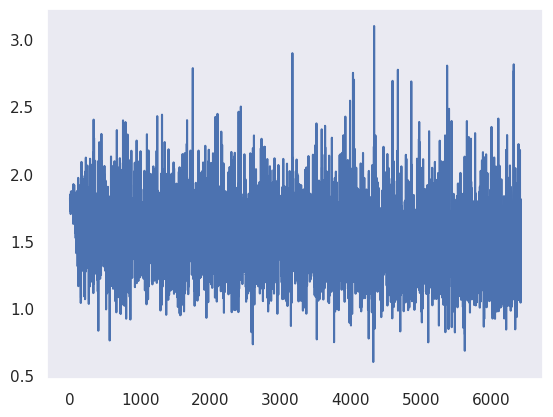

In [27]:
plt.plot(train_losses)

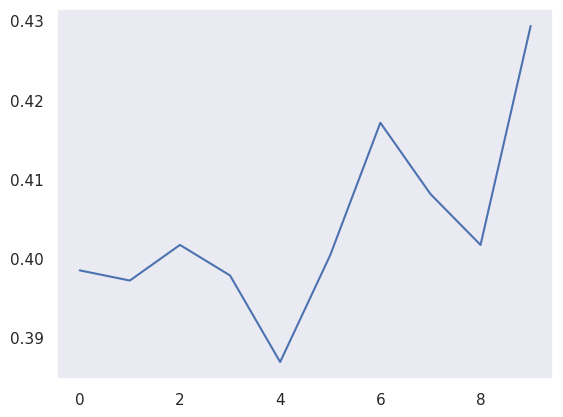

In [28]:
plt.plot(test_accuracy)

In [30]:
model_path = '../cremad_m12_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [31]:
del model
gc.collect()

70